In [65]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, assemble
import numpy as np
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from threading import Thread, Lock, Condition

In [66]:
num_players = 2
tosses = pow(num_players, 2)
k = 3*np.log2(num_players)
num_qubits = math.ceil(k)
upper_bound = pow(num_players,3)

lock = Lock()

c_messages = []
l_messages = []

c_measurements = []
l_measurements = []

In [67]:
def coin_toss(player_id, condition):  

    coin = QuantumCircuit(num_players)

    coin.h(0)

    for qubit in range(1,num_players):
        coin.cx(0,qubit)

    # coin.barrier()

    lock.acquire()
    try:
        for receiver in range(num_players):
            coin_results = [player_id, receiver, coin]
            
            c_messages.append(coin_results)
            # print(f'Player {player_id} tossed coin for player {receiver}')
    finally:
        lock.release()   

    with condition:
        if(len(c_messages) == tosses):
            condition.notify_all()

    return coin

In [68]:
cond = Condition()
coin = coin_toss(1, cond)
coin.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

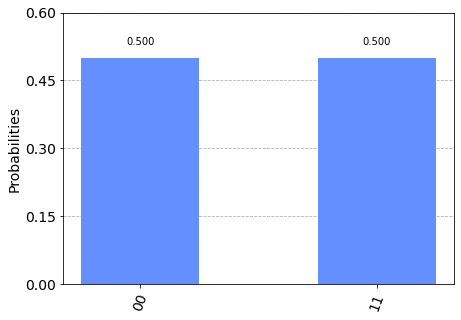

In [69]:
simulator = Aer.get_backend('aer_simulator')
coin.save_statevector()
result = simulator.run(assemble(coin)).result()
state = result.get_statevector()

plot_histogram(simulator.run(assemble(coin)).result().get_counts())

In [70]:
array_to_latex(state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

In [71]:
def leader_toss(player_id, condition):
    
    l_registers = []

    for a in range(num_players):
        q_name = 'q' + str(a)
        q_reg = QuantumRegister(num_qubits, q_name)
        l_registers.append(q_reg)


    leader = QuantumCircuit(*l_registers)

    # cr = ClassicalRegister(num_players*num_qubits, 'c')

    # leader.add_register(cr)

    for qubit in range(num_qubits):
        leader.h(l_registers[0][qubit])
    for a in range(1,num_players):
        for qubit in range(num_qubits):
            leader.cx(l_registers[0][qubit], l_registers[a][qubit])

    leader.barrier()   

    lock.acquire()
    try:
        for receiver in range(num_players):
            leader_results = [player_id, receiver, leader]

            l_messages.append(leader_results)
            print(f'Player {player_id} chose leader for player {receiver}')
    finally:
        lock.release()

    with condition:
        if(len(l_messages) == tosses):
            condition.notify_all()   

    return leader

In [72]:
l_cond = Condition()
leader = leader_toss(1, l_cond)
leader.draw()

Player 1 chose leader for player 0
Player 1 chose leader for player 1


┌───┐                ░ 
q0_0: ┤ H ├──■─────────────░─
      ├───┤  │             ░ 
q0_1: ┤ H ├──┼────■────────░─
      ├───┤  │    │        ░ 
q0_2: ┤ H ├──┼────┼────■───░─
      └───┘┌─┴─┐  │    │   ░ 
q1_0: ─────┤ X ├──┼────┼───░─
           └───┘┌─┴─┐  │   ░ 
q1_1: ──────────┤ X ├──┼───░─
                └───┘┌─┴─┐ ░ 
q1_2: ───────────────┤ X ├─░─
                     └───┘ ░

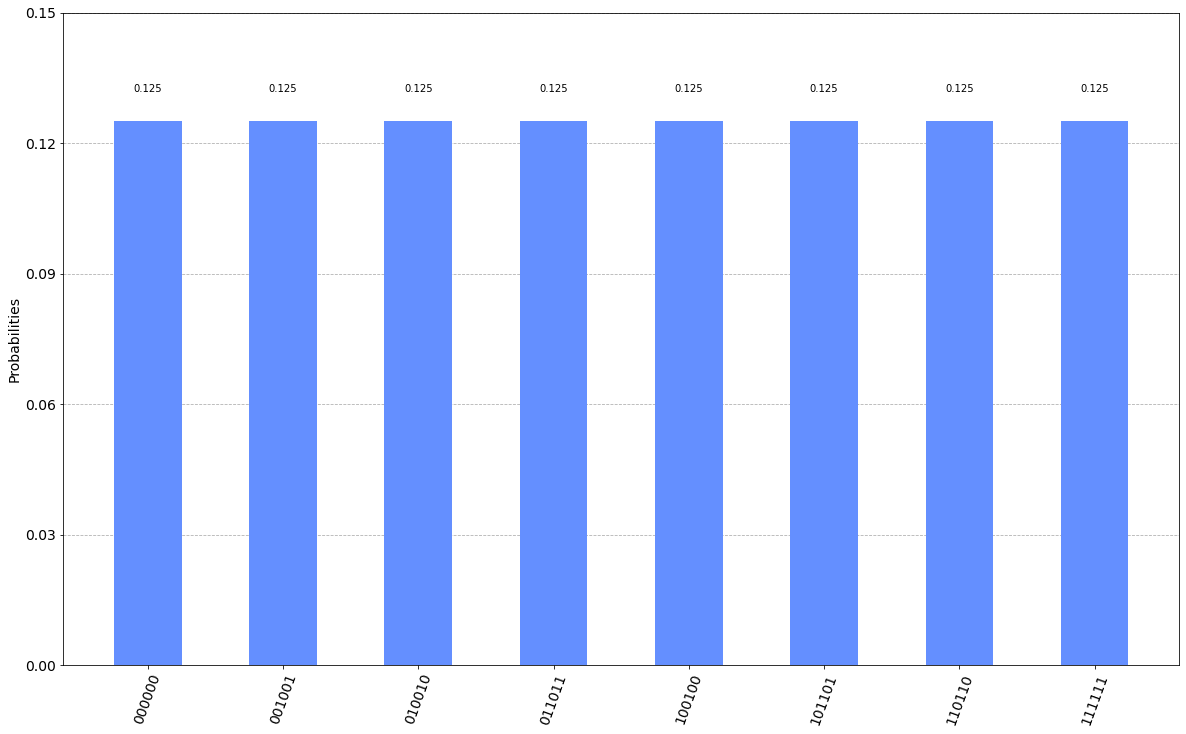

In [73]:
leader.save_statevector()
l_state = simulator.run(assemble(leader)).result().get_statevector()
l_hist = simulator.run(assemble(leader)).result().get_counts()
plot_histogram(l_hist, figsize=(20,12))


In [74]:
array_to_latex(l_state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>